In [ ]:
!pip install arcticdb

In [2]:
import time
import numpy as np
import pandas as pd
from datetime import datetime
from arcticdb import Arctic, QueryBuilder

<center>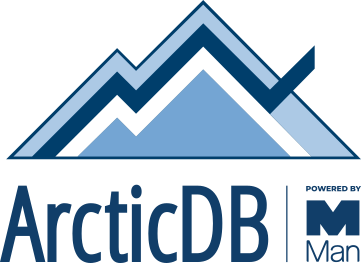
</center>

# ArcticDB Concepts and Terminology

* **Namespace** – Collections of libraries. Used to separate logical environments from each other. Analogous to database server.
* **Library** – Contains multiple symbols which are grouped in a certain way (different users, markets etc). Analogous to database.
* **Symbol** – Atomic unit of data storage. Identified by a string name. Data stored under a symbol strongly resembles a Pandas DataFrame. Analogous to tables.
* **Version** – Every modifying action (write, append, update) performed on a symbol creates a new version of that object.
* **Snapshot** – Data associated with all or some symbols at a particular point-in-time can be snapshotted and later retrieved via the read method.


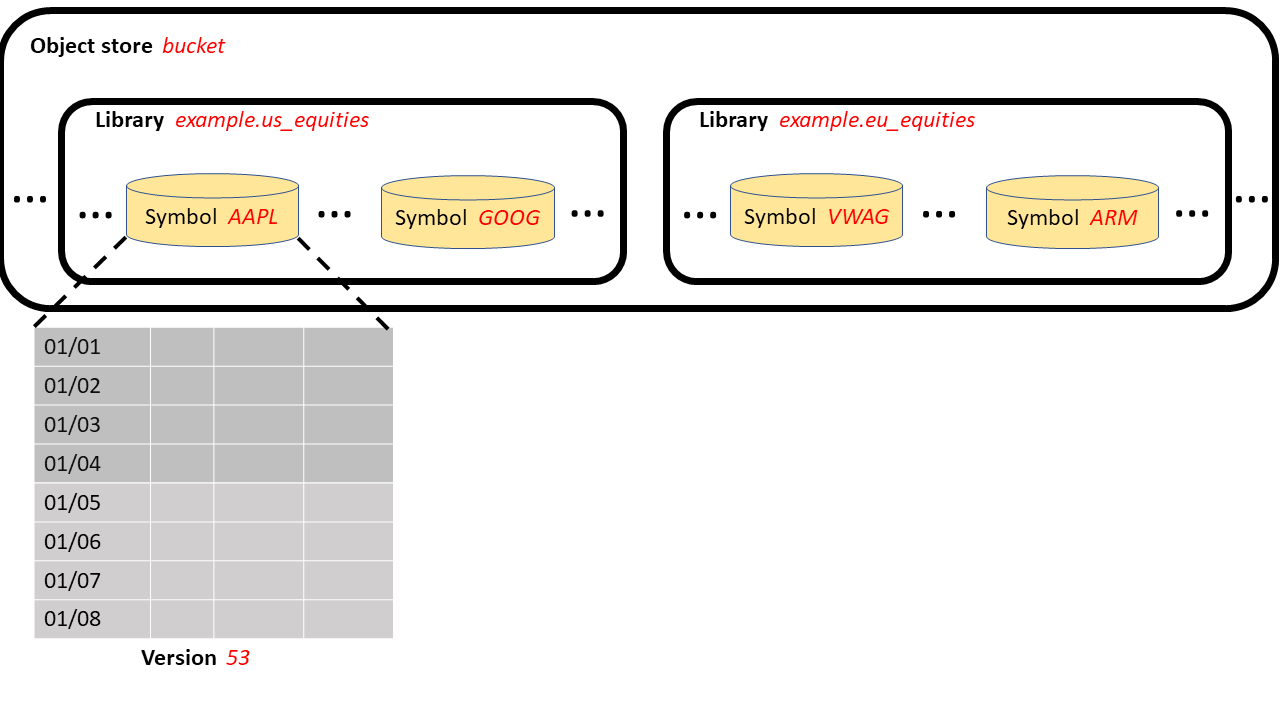

# ArcticDB is designed for Time Series data
Let's create a few small dataframes of daily data so we can see what's happening.

In [3]:
daily1 = pd.DataFrame(np.ones((4, 3))*1, index=pd.date_range('1/1/2023', periods=4, freq="D"), columns=list('ABC'))
daily1

,A,B,C
2023-01-01,1.0,1.0,1.0
2023-01-02,1.0,1.0,1.0
2023-01-03,1.0,1.0,1.0
2023-01-04,1.0,1.0,1.0


In [4]:
daily2 = pd.DataFrame(np.ones((4, 3))*2, index=pd.date_range('1/5/2023', periods=4, freq="D"), columns=list('ABC'))
daily2

,A,B,C
2023-01-05,2.0,2.0,2.0
2023-01-06,2.0,2.0,2.0
2023-01-07,2.0,2.0,2.0
2023-01-08,2.0,2.0,2.0


In [5]:
daily3 = pd.DataFrame(np.ones((4, 3))*3, index=pd.date_range('1/3/2023', periods=4, freq="D"), columns=list('ABC'))
daily3

,A,B,C
2023-01-03,3.0,3.0,3.0
2023-01-04,3.0,3.0,3.0
2023-01-05,3.0,3.0,3.0
2023-01-06,3.0,3.0,3.0


# Library Management

For this demo we will configure the LMDB file based backend.  ArcticDB achieves its high performance and scale when configured with an object store backend (e.g. S3).

In [6]:
arctic = Arctic("lmdb://arcticdb_demo")

You can have an unlimited number of libraries, but we will just create one to start with.

In [7]:
if 'sample' not in arctic.list_libraries():
    # library does not already exist
    arctic.create_library('sample')
lib = arctic.get_library('sample')

# Reading & writing data

### Read a pandas dataframe from source, and write it to the target

ArcticDB generally adheres to a philosphy of Pandas In, Pandas Out. **read** and **write** both work with Pandas DataFrames.

Note - within a library it is common to have many thousands of symbols.

In [8]:
write_record = lib.write("DAILY", daily1)
write_record

VersionedItem(symbol='DAILY', library='sample', data=n/a, version=0, metadata=None, host='LMDB(path=/content/arcticdb_demo)')

In [9]:
read_record = lib.read("DAILY")
read_record

VersionedItem(symbol='DAILY', library='sample', data=<class 'pandas.core.frame.DataFrame'>, version=0, metadata=None, host='LMDB(path=/content/arcticdb_demo)')

**NB:** You can version multiple symbols/tables together with a library level [_Snapshot_](https://docs.arcticdb.io/tutorials/snapshots/)!

In [10]:
read_record.data

,A,B,C
2023-01-01,1.0,1.0,1.0
2023-01-02,1.0,1.0,1.0
2023-01-03,1.0,1.0,1.0
2023-01-04,1.0,1.0,1.0


### Modifying Data

ArcticDB supports data modifications such as *update* and *append*.

<center>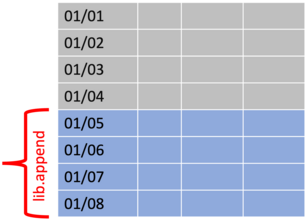</center>

In [11]:
lib.append("DAILY", daily2)
lib.read("DAILY").data

,A,B,C
2023-01-01,1.0,1.0,1.0
2023-01-02,1.0,1.0,1.0
2023-01-03,1.0,1.0,1.0
2023-01-04,1.0,1.0,1.0
2023-01-05,2.0,2.0,2.0
2023-01-06,2.0,2.0,2.0
2023-01-07,2.0,2.0,2.0
2023-01-08,2.0,2.0,2.0


<center>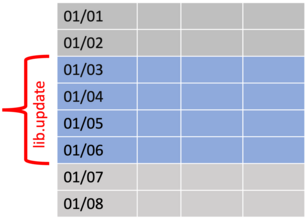</center>

In [12]:
lib.update("DAILY", daily3)
lib.read("DAILY").data

,A,B,C
2023-01-01,1.0,1.0,1.0
2023-01-02,1.0,1.0,1.0
2023-01-03,3.0,3.0,3.0
2023-01-04,3.0,3.0,3.0
2023-01-05,3.0,3.0,3.0
2023-01-06,3.0,3.0,3.0
2023-01-07,2.0,2.0,2.0
2023-01-08,2.0,2.0,2.0


### ArcticDB is bitemporal

All ArcticDB operations are versioned - rewind through time to understand historical revisions and enable **point-in-time analysis** of data!

In [13]:
# Rewind to version...
lib.read("DAILY", as_of=write_record.version).data

,A,B,C
2023-01-01,1.0,1.0,1.0
2023-01-02,1.0,1.0,1.0
2023-01-03,1.0,1.0,1.0
2023-01-04,1.0,1.0,1.0


# ArcticDB supports extremely large DataFrames

One typical use case is to store the history of >100k measures in one dataframe for easy timeseries and cross-sectional analysis.

<center>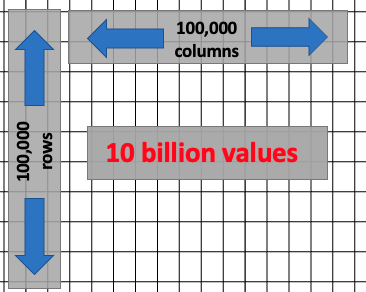</center>

For this demo notebook we'll just do 10,000 rows of hourly data by 10,000 columns of measures.

In [14]:
n = 10_000
large = pd.DataFrame(np.linspace(1, n, n)*np.linspace(1, n, n)[:,np.newaxis], columns=[f'c{i}' for i in range(n)], index=pd.date_range('1/1/2020', periods=n, freq="H"))
large.tail()

,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,...,c9990,c9991,c9992,c9993,c9994,c9995,c9996,c9997,c9998,c9999
2021-02-20 11:00:00,9996.0,19992.0,29988.0,39984.0,49980.0,59976.0,69972.0,79968.0,89964.0,99960.0,...,99870036.0,99880032.0,99890028.0,99900024.0,99910020.0,99920016.0,99930012.0,99940008.0,99950004.0,99960000.0
2021-02-20 12:00:00,9997.0,19994.0,29991.0,39988.0,49985.0,59982.0,69979.0,79976.0,89973.0,99970.0,...,99880027.0,99890024.0,99900021.0,99910018.0,99920015.0,99930012.0,99940009.0,99950006.0,99960003.0,99970000.0
2021-02-20 13:00:00,9998.0,19996.0,29994.0,39992.0,49990.0,59988.0,69986.0,79984.0,89982.0,99980.0,...,99890018.0,99900016.0,99910014.0,99920012.0,99930010.0,99940008.0,99950006.0,99960004.0,99970002.0,99980000.0
2021-02-20 14:00:00,9999.0,19998.0,29997.0,39996.0,49995.0,59994.0,69993.0,79992.0,89991.0,99990.0,...,99900009.0,99910008.0,99920007.0,99930006.0,99940005.0,99950004.0,99960003.0,99970002.0,99980001.0,99990000.0
2021-02-20 15:00:00,10000.0,20000.0,30000.0,40000.0,50000.0,60000.0,70000.0,80000.0,90000.0,100000.0,...,99910000.0,99920000.0,99930000.0,99940000.0,99950000.0,99960000.0,99970000.0,99980000.0,99990000.0,100000000.0


In [15]:
t1 = time.time()
lib.write('large', large)
t2 = time.time()
print(f'Wrote {n*n/(t2-t1)/1e6:.2f} million floats per second.')

Wrote 13.30 million floats per second.


You can select out rows and columns efficiently, necessary when the data doesn't fit into ram.

In [16]:
subframe = lib.read(
    "large",
    columns=["c0", "c1", "c5000", "c5001", "c9998", "c9999"],
    date_range=(datetime(2020, 6, 13, 8), datetime(2020, 6, 13, 13))
).data
subframe

,c0,c1,c5000,c5001,c9998,c9999
2020-06-13 08:00:00,3945.0,7890.0,19728945.0,19732890.0,39446055.0,39450000.0
2020-06-13 09:00:00,3946.0,7892.0,19733946.0,19737892.0,39456054.0,39460000.0
2020-06-13 10:00:00,3947.0,7894.0,19738947.0,19742894.0,39466053.0,39470000.0
2020-06-13 11:00:00,3948.0,7896.0,19743948.0,19747896.0,39476052.0,39480000.0
2020-06-13 12:00:00,3949.0,7898.0,19748949.0,19752898.0,39486051.0,39490000.0
2020-06-13 13:00:00,3950.0,7900.0,19753950.0,19757900.0,39496050.0,39500000.0


# ArcticDB supports extremely long DataFrames
Another typical use case is high frequency data with billions of rows.

For this demo notebook we will just try a modest 100 million rows of second frequency data.

In [17]:
n = 100_000_000
long = pd.DataFrame(np.linspace(1, n, n), columns=['Price'], index=pd.date_range('1/1/2020', periods=n, freq="S"))
long.tail()

,Price
2023-03-03 09:46:35,99999996.0
2023-03-03 09:46:36,99999997.0
2023-03-03 09:46:37,99999998.0
2023-03-03 09:46:38,99999999.0
2023-03-03 09:46:39,100000000.0


In [18]:
t1 = time.time()
lib.write('long', long)
t2 = time.time()
print(f'Wrote {n/(t2-t1)/1e6:.2f} million floats per second.')

Wrote 12.20 million floats per second.


### You can query the data with with the familiarity of Pandas and the efficiency of C++

For more information please check out our [QueryBuilder docs](https://docs.arcticdb.io/api/query_builder).

In [19]:
%%time
q = QueryBuilder()
q = q[(q["Price"] > 49e6) & (q["Price"] < 51e6)]
filtered = lib.read("long", query_builder=q).data

CPU times: user 3.07 s, sys: 525 ms, total: 3.6 s
Wall time: 2.3 s


In [20]:
len(filtered)

1999999

In [21]:
filtered.tail()

,Price
2021-08-13 06:39:54,50999995.0
2021-08-13 06:39:55,50999996.0
2021-08-13 06:39:56,50999997.0
2021-08-13 06:39:57,50999998.0
2021-08-13 06:39:58,50999999.0


# Where to go from here?

1. Read the [docs](https://docs.arcticdb.io/)
2. Signup for Slack via [our website](https://arcticdb.io/)
3. Checkout the code on [Github](https://github.com/man-group/ArcticDB)